# Natural Language Processing   

Mini-Challenge 1 (LE3-LE5)   
Yannic & Ben  


# Aufgabe

You evaluate 2 different classification systems on a text classification task (examples below). You argument why you chose these systems for that case and you build, train and evaluate the system. You also do a thorough error analysis and propose theories on how to improve the systems, especially also by analysing individual cases and comparing the predictions of each system. At least one of the systems is based on a fine-tuned deep learning model.

Here you can use data from shared tasks, such as semeval, kaggle, codalab or paperwithcode for text classification.

You can submit as a group of 2 but each one has to have a significant contribution. Submission is given as a gitlab repo. I will track with the commit history if there was  a significant contribution from each participant. The repo should include the report, a python notebook to reproduce the results and a wiki with a journal or git issues that document the progress of your mini-challenge.

Since many parts of code can be online, the most important part of the submission will be the report and evaluation of the results. In the report you describe which system you used, which are the theory behind it and why you chose it. The evaluation you describe the metric chose, why this metric is good for the use case and discuss the results of the experiments and some predictions on individual test samples. Bonus points will be given if you show, that you implemented the systems yourself, and the progress/errors are documented through commits.

ADDENDUM: The classification systems can be for example tf-idf-svm, cnns or transformers, see https://gitlab.fhnw.ch/fernando.benites/npr-21-fs/-/tree/master/text_classification/20news_group for an applied example. There are other ways to go, and I am open for suggestions. Please try to understand the systems, this can be handy in the error analysis/evaluation/report or in the exam. Don't use the 20newsgroup dataset. The repo will be used in the deep dive and so this dataset is already "taken". If you receive a 404 on the repo, please contact me, I'll add you to the repo, then it should work.

Some other starting points:

https://lionbridge.ai/articles/using-deep-learning-for-end-to-end-multiclass-text-classification/

BETTER: https://medium.com/analytics-vidhya/sentiment-analysis-on-amazon-reviews-using-tf-idf-approach-c5ab4c36e7a1

GOOD: https://colab.research.google.com/github/patrickvankessel/AAPOR-Text-Analysis-2019/blob/master/Tutorial.ipynb#scrollTo=9wJQJUDHkM5w

BAD: https://medium.com/@qempsil0914/machine-learning-nlp-text-classification-with-amazon-review-data-using-python3-step-by-step-3fb0cc0cecc1

https://paperswithcode.com/task/text-classification

https://fbenites.github.io/GermEval/

https://medium.com/analytics-vidhya/fine-tuning-bert-language-model-to-get-better-results-on-text-classification-3dac5e3c348e

https://github.com/Shivampanwar/Bert-text-classification/blob/master/bert_language_model_with_sequence_classification.ipynb


# Installing Packages

In [1]:
# Standard Data Science Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# sklearn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# SVM Classifier
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# nltk imports
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')

# Read Dataset

In [2]:
# Read booksumaries.txt Dataset
df = pd.read_csv('data/booksummaries.txt', 
                 sep="\t", 
                 header=None, 
                 names=["Wikipedia ID", "Freebase ID", "Book Title", "Book Author", "Pub date","Genres","Summary"],
                 dtype={"Wikipedia ID": np.int32, "Freebase ID": str, "Book Title": str, "Book Author": str, "Pub date": str, "Genres": str, "Summary": str})

display(df.info())
display(df.head())

def extract_genres(genre_str: str):
    try:
        genre_data = json.loads(genre_str)
        return list(genre_data.values())
    except:
        (json.decoder.JSONDecodeError, TypeError)
        return np.nan

# apply extract_genres function to the Genres column
df['Genres'] = df['Genres'].apply(extract_genres)
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16559 entries, 0 to 16558
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Wikipedia ID  16559 non-null  int32 
 1   Freebase ID   16559 non-null  object
 2   Book Title    16559 non-null  object
 3   Book Author   14177 non-null  object
 4   Pub date      10949 non-null  object
 5   Genres        12841 non-null  object
 6   Summary       16559 non-null  object
dtypes: int32(1), object(6)
memory usage: 841.0+ KB


None

,Wikipedia ID,Freebase ID,Book Title,Book Author,Pub date,Genres,Summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...


,Wikipedia ID,Freebase ID,Book Title,Book Author,Pub date,Genres,Summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"[Roman à clef, Satire, Children's literature, ...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"[Science Fiction, Novella, Speculative fiction...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"[Existentialism, Fiction, Absurdist fiction, N...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"[Hard science fiction, Science Fiction, Specul...",The novel posits that space around the Milky ...


In [3]:
# drop rows that contains NaN Values for Genres and Summary
df_clean = df.dropna(subset=['Genres', 'Summary'])

# remove duplicated rows 
df_clean = df_clean.drop_duplicates(subset=['Summary'])

display(df_clean.info())

# display the cleaned dataframe
display(df_clean.head())

# calculate the number of dropped rows 
print("Number of dropped rows: ", df.shape[0] - df_clean.shape[0])
# calculate the relative number of dropped rows in percent and round to 2 decimal places
print("Relative number of dropped rows in percent: ", round(((df.shape[0] - df_clean.shape[0]) / df.shape[0]) * 100, 2), "%")
print("Number of unique genres: ", df_clean['Genres'].explode().nunique())

<class 'pandas.core.frame.DataFrame'>
Index: 12817 entries, 0 to 16558
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Wikipedia ID  12817 non-null  int32 
 1   Freebase ID   12817 non-null  object
 2   Book Title    12817 non-null  object
 3   Book Author   12031 non-null  object
 4   Pub date      9653 non-null   object
 5   Genres        12817 non-null  object
 6   Summary       12817 non-null  object
dtypes: int32(1), object(6)
memory usage: 751.0+ KB


None

,Wikipedia ID,Freebase ID,Book Title,Book Author,Pub date,Genres,Summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"[Roman à clef, Satire, Children's literature, ...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"[Science Fiction, Novella, Speculative fiction...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"[Existentialism, Fiction, Absurdist fiction, N...",The text of The Plague is divided into five p...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"[Hard science fiction, Science Fiction, Specul...",The novel posits that space around the Milky ...
5,2152,/m/0x5g,All Quiet on the Western Front,Erich Maria Remarque,1929-01-29,"[War novel, Roman à clef]","The book tells the story of Paul Bäumer, a Ge..."


Number of dropped rows:  3742
Relative number of dropped rows in percent:  22.6 %
Number of unique genres:  227


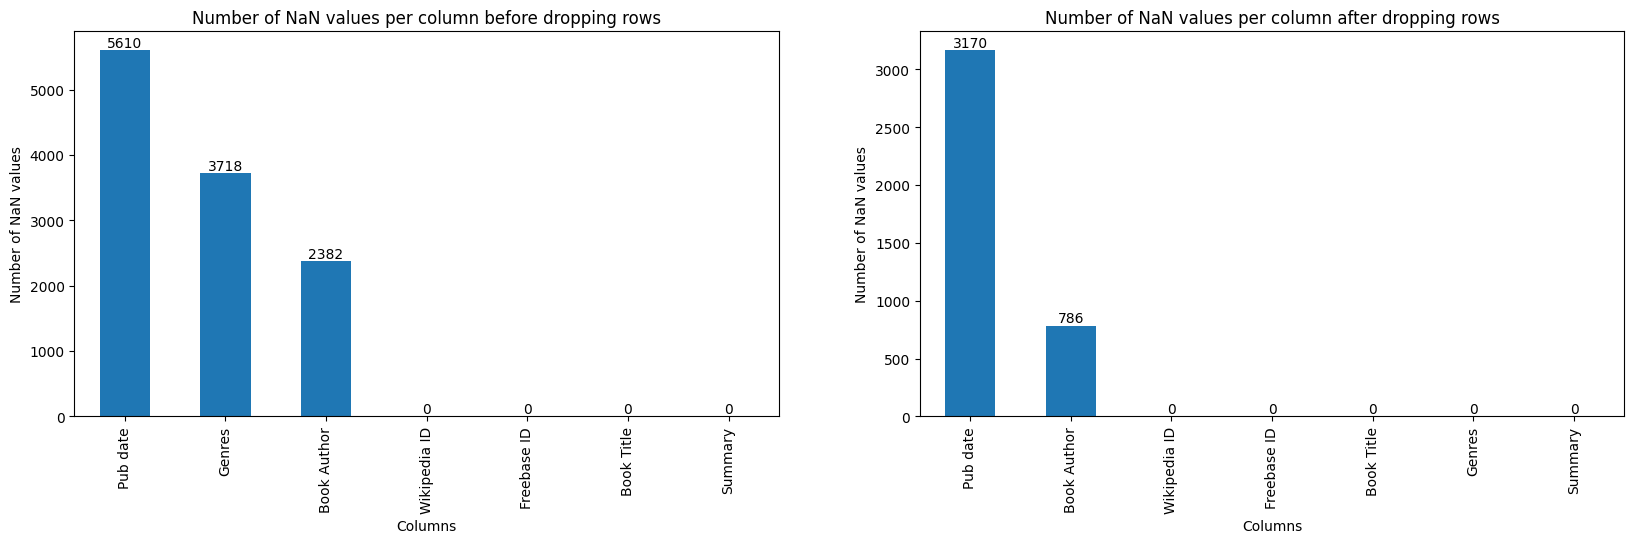

In [4]:
# drop rows that contains NaN Values for Genres and Summary
df_clean = df.dropna(subset=['Genres', 'Summary'])

# make both plots in one figure
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
df.isna().sum().sort_values(ascending=False).plot(kind='bar', ax=axes[0])
for index, value in enumerate(df.isna().sum().sort_values(ascending=False)):
    axes[0].text(index, value, str(value), ha='center', va='bottom', fontsize=10)
axes[0].set_title('Number of NaN values per column before dropping rows')
axes[0].set_xlabel('Columns')
axes[0].set_ylabel('Number of NaN values')
df_clean.isna().sum().sort_values(ascending=False).plot(kind='bar', ax=axes[1])
for index, value in enumerate(df_clean.isna().sum().sort_values(ascending=False)):
    axes[1].text(index, value, str(value), ha='center', va='bottom', fontsize=10)
axes[1].set_title('Number of NaN values per column after dropping rows')
axes[1].set_xlabel('Columns')
axes[1].set_ylabel('Number of NaN values')
plt.show()

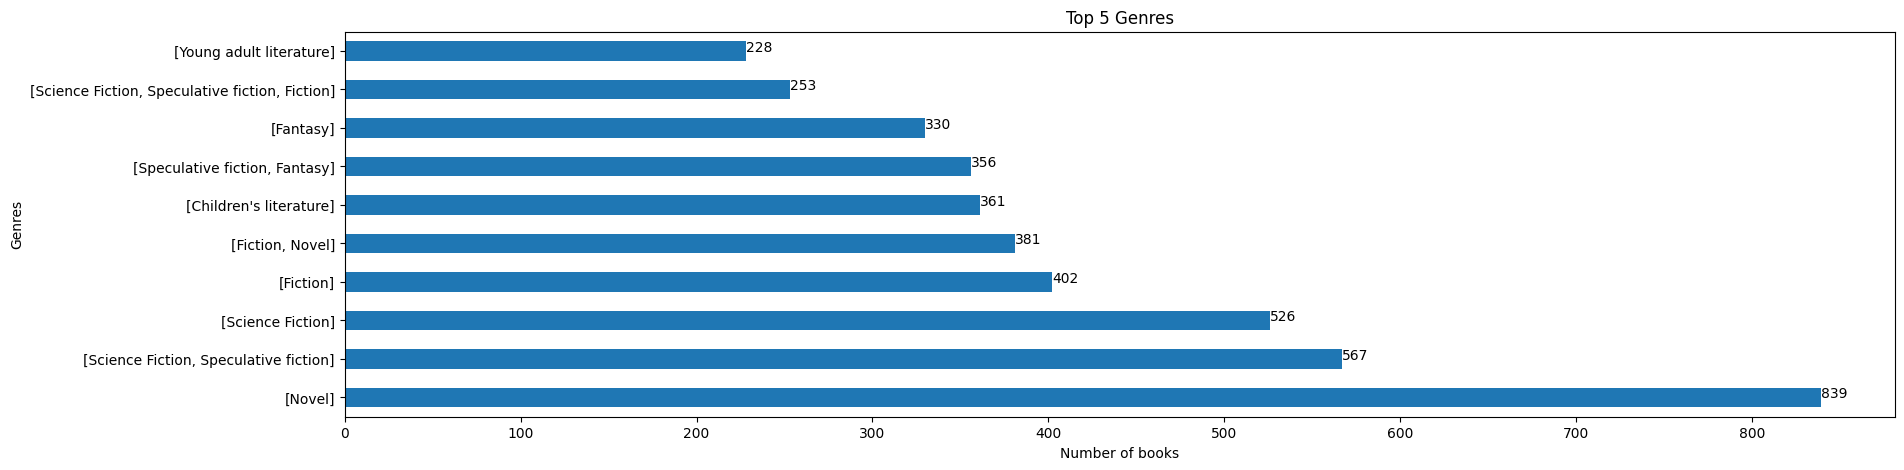

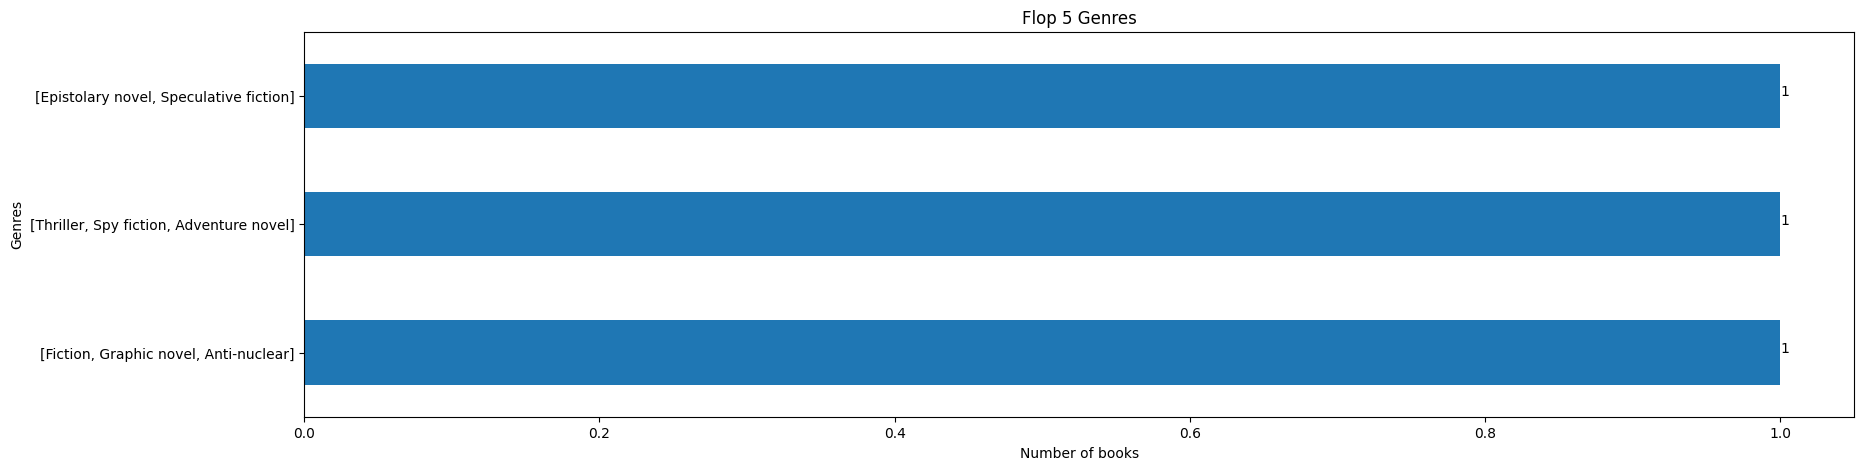

In [5]:
# Top 10 Genres
df_clean["Genres"].value_counts().head(n=10).plot(kind='barh', figsize=(20, 5))
# add number to the bars
for index, value in enumerate(df_clean["Genres"].value_counts().head(n=10)):
    plt.text(value, index, str(value), fontsize=10)
plt.title('Top 5 Genres')
plt.xlabel('Number of books')
plt.ylabel('Genres')
plt.show()

# Flop 3 Genres
df_clean["Genres"].value_counts().tail(3).plot(kind='barh', figsize=(20, 5))
# add number to the bars
for index, value in enumerate(df_clean["Genres"].value_counts().tail(3)):
    plt.text(value, index, str(value))
plt.title('Flop 5 Genres')
plt.xlabel('Number of books')
plt.ylabel('Genres')
plt.show()


# Data NLP Pre-processing

In [6]:
# select the relevant columns
df_clean = df_clean[['Genres', 'Summary']].copy()

# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))

# preprocess Summary column and add it to the dataframe
def preprocess_summary(summary_text: str):
    # case folding to lower case 
    summary_text = summary_text.lower()
    # remove punctuation, kommas, dots, and other special characters
    summary_text = summary_text.translate(str.maketrans('', '', string.punctuation))
    # remove stopwords
    summary_text = [word for word in summary_text.split() if word not in stop_words]
    # lemmatize words
    summary_text = [WordNetLemmatizer().lemmatize(word) for word in summary_text]
    # Tokenize
    summary_text = word_tokenize(" ".join(summary_text))
    return summary_text

# apply preprocess function to Summary column
df_clean['Preprocess Summary'] = df_clean['Summary'].apply(preprocess_summary)

# display the cleaned dataframe 
display(df_clean.head())


,Genres,Summary,Preprocess Summary
0,"[Roman à clef, Satire, Children's literature, ...","Old Major, the old boar on the Manor Farm, ca...","[old, major, old, boar, manor, farm, call, ani..."
1,"[Science Fiction, Novella, Speculative fiction...","Alex, a teenager living in near-future Englan...","[alex, teenager, living, nearfuture, england, ..."
2,"[Existentialism, Fiction, Absurdist fiction, N...",The text of The Plague is divided into five p...,"[text, plague, divided, five, part, town, oran..."
4,"[Hard science fiction, Science Fiction, Specul...",The novel posits that space around the Milky ...,"[novel, posit, space, around, milky, way, divi..."
5,"[War novel, Roman à clef]","The book tells the story of Paul Bäumer, a Ge...","[book, tell, story, paul, bäumer, german, sold..."


In [7]:
def pos_tag_text(tokens: list):
    pos_tagged = nltk.pos_tag(tokens)
    # Returning the tags as a string
    return pos_tagged

# apply pos_tag_text function to Summary column
df_clean['POS Tagged Summary'] = df_clean['Preprocess Summary'].apply(pos_tag_text)

# display the cleaned dataframe
display(df_clean.head())

,Genres,Summary,Preprocess Summary,POS Tagged Summary
0,"[Roman à clef, Satire, Children's literature, ...","Old Major, the old boar on the Manor Farm, ca...","[old, major, old, boar, manor, farm, call, ani...","[(old, JJ), (major, JJ), (old, JJ), (boar, NN)..."
1,"[Science Fiction, Novella, Speculative fiction...","Alex, a teenager living in near-future Englan...","[alex, teenager, living, nearfuture, england, ...","[(alex, JJ), (teenager, NN), (living, VBG), (n..."
2,"[Existentialism, Fiction, Absurdist fiction, N...",The text of The Plague is divided into five p...,"[text, plague, divided, five, part, town, oran...","[(text, NN), (plague, NN), (divided, VBD), (fi..."
4,"[Hard science fiction, Science Fiction, Specul...",The novel posits that space around the Milky ...,"[novel, posit, space, around, milky, way, divi...","[(novel, JJ), (posit, NN), (space, NN), (aroun..."
5,"[War novel, Roman à clef]","The book tells the story of Paul Bäumer, a Ge...","[book, tell, story, paul, bäumer, german, sold...","[(book, NN), (tell, VB), (story, NN), (paul, N..."


In [8]:
# Create a function where we only keep the Genres that have a length of 1 
def filter_genres(genres: list):
    return len(genres) == 1

# copy dataframe for filtering
df_mono_variable = df_clean.copy()

# apply filter_genres function to Genres column
mask = df_mono_variable['Genres'].apply(filter_genres)

# use the mask to filter the dataframe
df_mono_variable = df_mono_variable[mask].reset_index(drop=True)

# display the filtered dataframe
display(df_mono_variable.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4555 entries, 0 to 4554
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Genres              4555 non-null   object
 1   Summary             4555 non-null   object
 2   Preprocess Summary  4555 non-null   object
 3   POS Tagged Summary  4555 non-null   object
dtypes: object(4)
memory usage: 142.5+ KB


None

# Feature Extraction

Als Baseline Modell nutzen wir tf-idf svm auf den einfachen Datensatz indem als Target nur eine Variable vorkommt. 

In [9]:
# Re Format columns Genre and Tokens (Preprocess Summary) into string
df_mono_variable['Genres'] = df_mono_variable['Genres'].apply(lambda x: ' '.join(x))
df_mono_variable['Preprocess Summary'] = df_mono_variable['Preprocess Summary'].apply(lambda x: ' '.join(x))

# split the dataframe into train and test data
X_train, X_test, Y_train, Y_test  = train_test_split(df_mono_variable["Preprocess Summary"], 
                                     df_mono_variable["Genres"],
                                     test_size=0.2, 
                                     random_state=42)

# get shape of train and test data
print("Train: ",X_train.shape,Y_train.shape,"Test: ",(X_test.shape,Y_test.shape))

# initialize tfidf vectorizer
vectorizer = TfidfVectorizer()

# fit and transform the vectorizer on the train data
X_train = vectorizer.fit_transform(X_train)

# transform the vectorizer on the test data
X_test = vectorizer.transform(X_test)

# display the shape of the train and test data
print("Train: ",X_train.shape,"Test: ",X_test.shape)

# initialize the classifier
clf = SVC()

# fit the classifier on the train data
clf.fit(X_train, Y_train)

# predict the labels on the test data
Y_pred = clf.predict(X_test)

# calculate the accuracy score
print("Accuracy Score: ", accuracy_score(Y_test, Y_pred))


Train:  (3644,) (3644,) Test:  ((911,), (911,))


Train:  (3644, 53192) Test:  (911, 53192)
Accuracy Score:  0.35236004390779363


# Predictions

# Evaluation